In [44]:
# Adapted from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
from tqdm import tqdm_notebook as tqdm
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "./data/lenet_mnist_model.pth"
use_cuda = True

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

9920512it [00:05, 1826248.95it/s]                             
32768it [00:00, 105025.63it/s]           
1654784it [00:01, 1243719.67it/s]                             
8192it [00:00, 41165.11it/s]            


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw
Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw
Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw
Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!
CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
def fgsm_attack(image: torch.Tensor, epsilon: float, data_grad: torch.Tensor):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [45]:
def test(model: torch.nn, device: torch.device, test_loader: torch.utils.data.DataLoader, epsilon: float):
    wrong, correct, adv_success = 0, 0, 0
    adv_examples = []
    
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        
        data.requires_grad = True # This enables a gradient based attack such as fgsm
        
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        
        if init_pred.item() != target.item():
            wrong += 1
        else:
            # Prediction was correct, try to fool the network
            correct += 1
        
            loss = F.nll_loss(output, target)
            
            model.zero_grad()
            
            loss.backward()
        
            data_grad = data.grad.data
            
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
            
            output = model(perturbed_data)
            
            adversarial_pred = output.max(1, keepdim=True)[1] # max returns a tuple (values, indices)
            if np.random.rand() > 0.9:
                perturbed_arr = perturbed_data.detach().cpu().numpy()
                adv_examples.append((target.item(), adversarial_pred.item(), perturbed_arr))
        
            if adversarial_pred.item() != target.item():
                adv_success += 1
    
    print(f'Correct: {correct}; Wrong: {wrong}')
    print(f'Adversarial Successes: {adv_success}')
    acc =  correct / (wrong + correct)
    return acc, adv_examples

C:\Users\rapha\Desktop\ai-trainer\envs\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Correct: 9810; Wrong: 190
Adversarial Successes: 0
Accuracy for epsilon=0: 0.981

Correct: 9810; Wrong: 190
Adversarial Successes: 384
Accuracy for epsilon=0.05: 0.981

Correct: 9810; Wrong: 190
Adversarial Successes: 1300
Accuracy for epsilon=0.1: 0.981

Correct: 9810; Wrong: 190
Adversarial Successes: 2984
Accuracy for epsilon=0.15: 0.981

Correct: 9810; Wrong: 190
Adversarial Successes: 5509
Accuracy for epsilon=0.2: 0.981

Correct: 9810; Wrong: 190
Adversarial Successes: 7728
Accuracy for epsilon=0.25: 0.981

Correct: 9810; Wrong: 190
Adversarial Successes: 8941
Accuracy for epsilon=0.3: 0.981


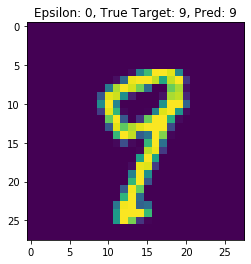

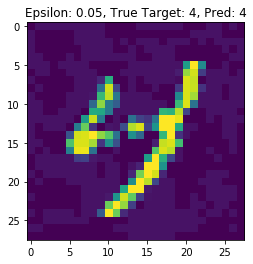

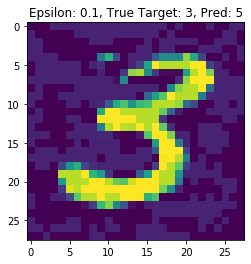

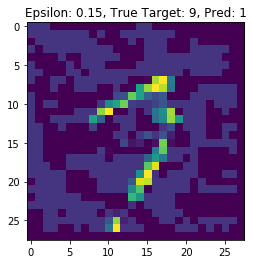

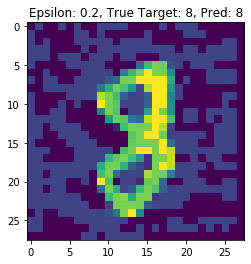

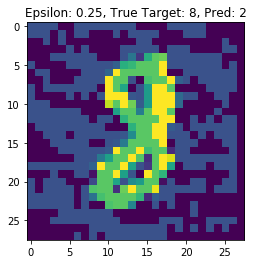

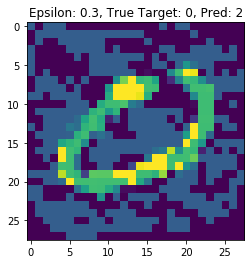

In [47]:
import random
for epsilon in epsilons:
    acc, meta = test(model, device, test_loader, epsilon=epsilon)
    true_target, adv_pred, adv_ex = random.choice(meta)
    plt.title(f"Epsilon: {epsilon}, True Target: {true_target}, Pred: {adv_pred}")
    plt.imshow(adv_ex.squeeze())
    plt.show()
    print(f"Accuracy for epsilon={epsilon}: {acc}")
